In [1]:
from netdeployonnx.client.experiment_helper import (  # noqa: F403
    get_data_overview,
    load_results,
    math,
    np,
    pd,
    plt,
    sns,
    stats,
)
from collections import defaultdict
from pathlib import Path
import os

#pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 130)

notebook_path = Path(os.getcwd())
results_path = notebook_path # .parent.parent # we should be in /netdeployonnx/client/experiment.ipynb, so we end up in /
figures_path = results_path.parent.parent / "documentation" / "figures"
print(results_path, figures_path)
assert results_path.exists()
assert figures_path.exists(), f"{figures_path} does not exist"
assert str(figures_path).endswith('/_Masterarbeit_SS24/documentation/figures')

/home/vscode/_Masterarbeit_SS24/hannah-env/service /home/vscode/_Masterarbeit_SS24/documentation/figures


In [2]:
weights = defaultdict(lambda: 0)
nice_network_names = defaultdict(lambda: "")

nice_network_names.update({
    'cifar10_short.onnx':"CIFAR10 (5 Layer)",
    'cifar10.onnx':"CIFAR10",
    'ai85-bayer2rgb-qat8-q.pth.onnx':"Bayer2RGB",
    'ai85-cifar10-qat8-q.pth.onnx':"CIFAR10 quant.",
    'ai85-cifar100-qat8-q.pth.onnx':"CIFAR100 quant.",
    'ai85-faceid_112-qat-q.pth.onnx':"FACEID-112 quant.",
    'ai85-kws20_v3-qat8-q.pth.onnx':"KWS20v3 quant.",
})

weights.update({
    # "cifar10_short.onnx": 49152,
    # "cifar10.onnx": 302606,
    # "ai85-bayer2rgb-qat8-q.pth.onnx": 184,
    # "ai85-cifar10-qat8-q.pth.onnx": 303054,
    # "ai85-cifar100-qat8-q.pth.onnx": 349224,
    # "ai85-faceid_112-qat-q.pth.onnx": 893585,
    # "ai85-kws20_v3-qat8-q.pth.onnx": 170127,
    "cifar10_short.onnx": 42944,
    "cifar10.onnx": 302602,
    "ai85-bayer2rgb-qat8-q.pth.onnx": 99,
    "ai85-cifar10-qat8-q.pth.onnx": 302602,
    "ai85-cifar100-qat8-q.pth.onnx": 348772,
    "ai85-faceid_112-qat-q.pth.onnx": 892016,
    "ai85-kws20_v3-qat8-q.pth.onnx": 170125,
})

nice_colnames = {
    '_check_model': "Model validation",
    'layout_transform':'Transforming the network',
    'compile_instructions':'Compilation of  Instructions',
    'execute':'Execution and device information transfer',
    }
nice_metrics = {
    'inference': "Inference",
    'weights_loading': "Loading of Weights",
    'input_loading': "Loading of Inputs",
}

In [3]:
df = load_results(results_path / "results.yaml")
list(df.keys())
df['experiment_idx'] = pd.factorize(df['experiment'])[0]
df['network_idx'] = pd.factorize(df['option_network_name'])[0]
df_filtered = df.drop(columns=[
    'experiment',
    'date',
    'samplepoints',
    'option_network_name'
    ])
for column_name in df_filtered.columns:
    # df_filtered[column_name] = pd.to_numeric(df_filtered[column_name])
    if df_filtered[column_name].dtype == 'bool':
        df_filtered[column_name] = df_filtered[column_name].astype('int64')

assert all(x in ['int64', 'float64'] for x in df_filtered.dtypes)
df['option_network_name'].unique()
df['network_size'] = df['option_network_name'].apply(lambda x:weights[x])
df = df.sort_values(by=['network_size'])

/home/vscode/_Masterarbeit_SS24/hannah-env/service/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2027: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


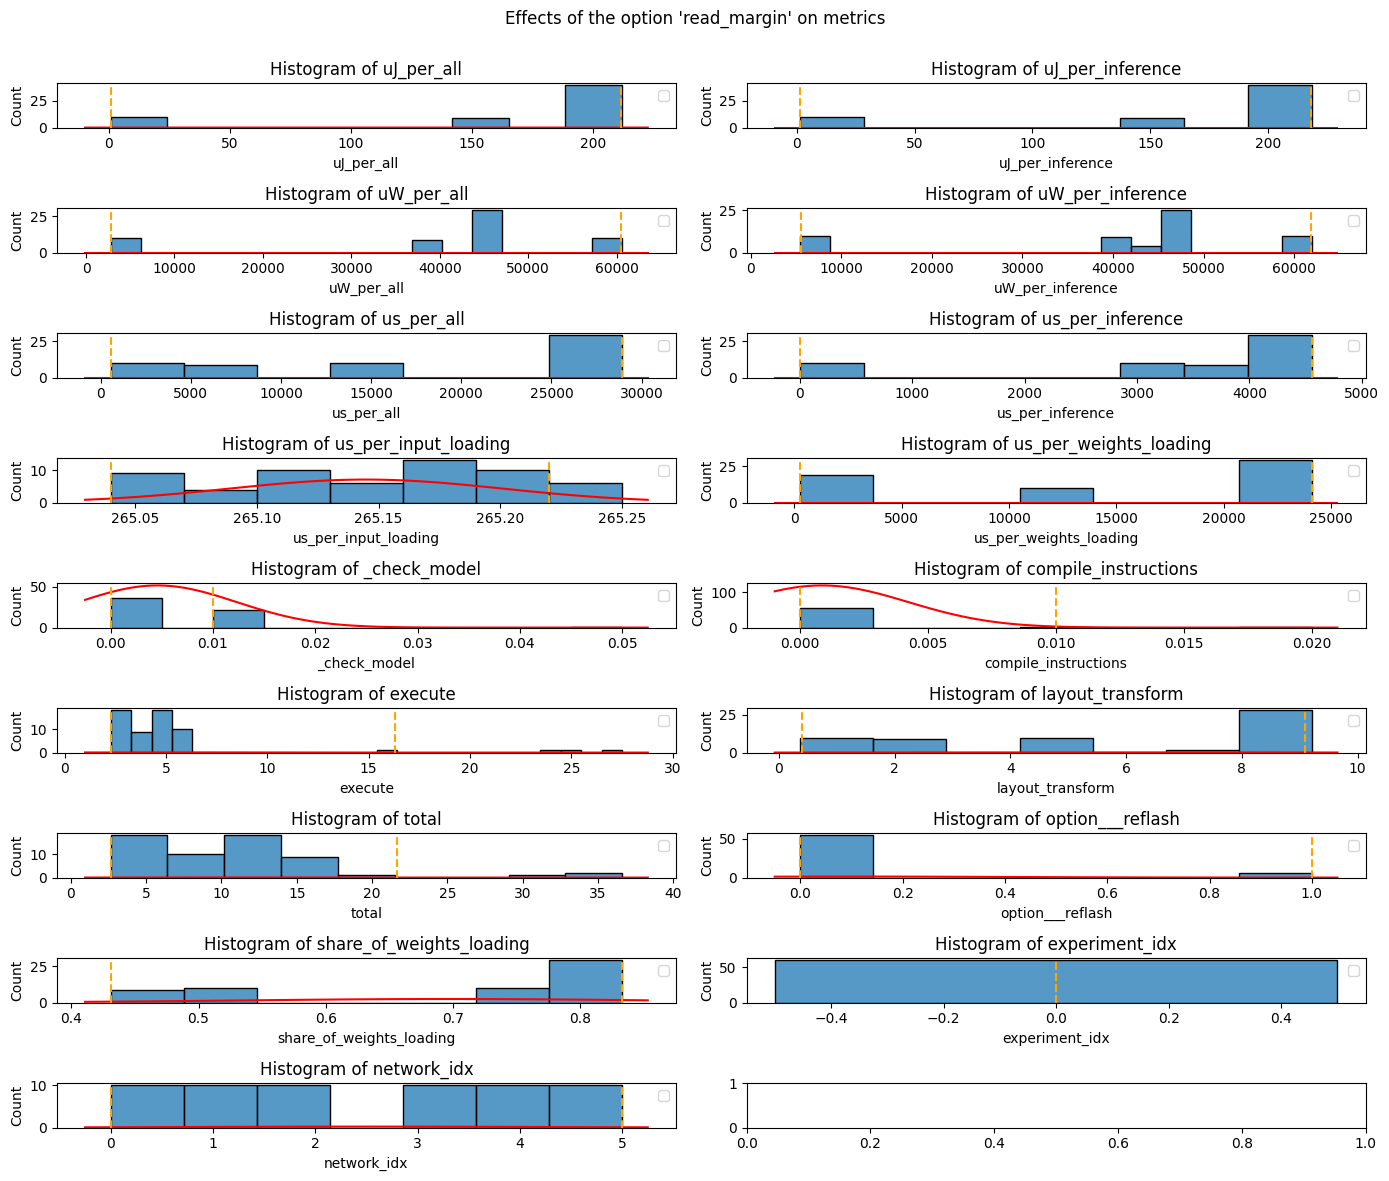

In [4]:
quantil = 0.95

def check_for_flash_vs_noflash():
    # can i see a difference between with and without flashing
    grouped = df.groupby(['experiment_idx', 'option___reflash']).mean('deploy').reset_index()
    # relative = grouped.pct_change()
    grouped_with_zero = [col for col in grouped.columns if (grouped[col] == 0).any()]
    relative_diffs = grouped.drop(columns=grouped_with_zero).pct_change().dropna()
    assert all(relative_diffs < 0.01) # diff is smaller than 1%

check_for_flash_vs_noflash()
data_overview_plot = get_data_overview(df_filtered.drop(columns=['uJ_per_input_loading', 'uJ_per_weights_loading','uW_per_input_loading', 'uW_per_weights_loading']))


## Metrics between nets and flashing vs not flashing

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (1.0, 0.4980392156862745, 0.054901960784313725, 1.0), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)]


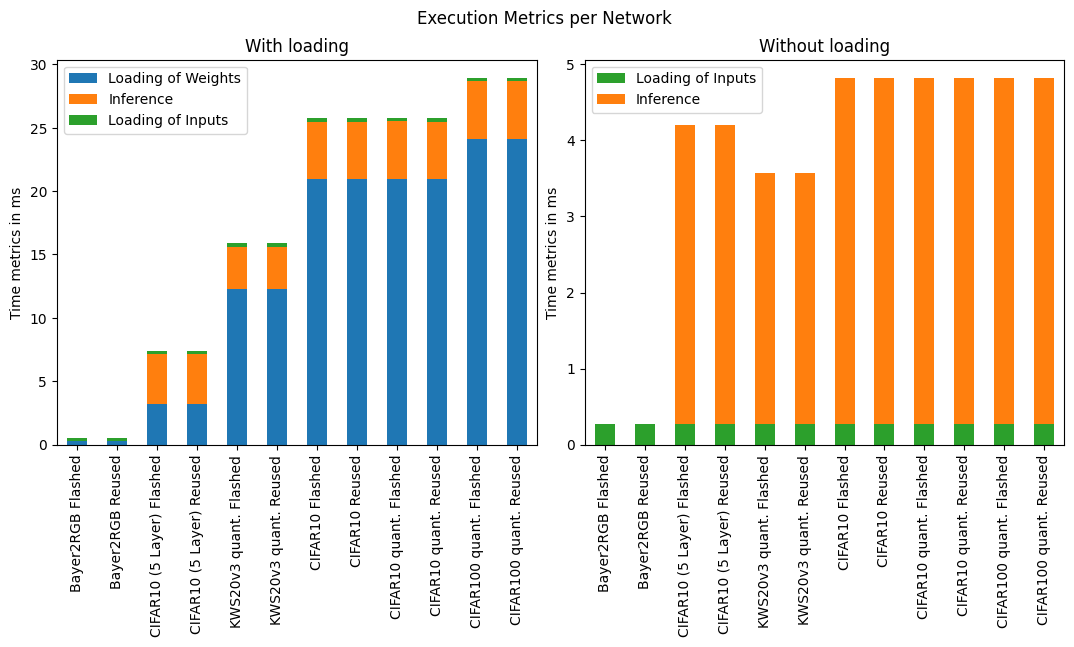

<Figure size 640x480 with 0 Axes>

In [5]:
# print(df_filtered.columns)
df_percents = pd.DataFrame()
df_percents['Option'] = df_filtered['option___reflash'].apply(lambda x: 'Flashed' if x else 'Reused')
df_percents['Network'] = df['option_network_name'].apply(lambda x: nice_network_names[x])
df_percents['network_size'] =  df['option_network_name'].apply(lambda x: weights[x])

for k in ['inference','weights_loading', 'input_loading']:
    df_percents[nice_metrics[k]] = df_filtered[f'us_per_{k}'] #/ df_filtered['us_per_all']

df_percents_indexed = df_percents.set_index(['Network', 'Option']).apply(lambda x: x / 1000, axis=1)
df_percents_grouped = df_percents_indexed.groupby(['Network', 'Option']).mean().sort_values(by=['network_size'])

df_percents_grouped.index = [f'{net} {option}' for net, option in df_percents_grouped.index]

fig, axes = plt.subplots(1, 2, figsize=(13,5))
# Plot the stacked bar chart
df_percents_grouped_displayed = df_percents_grouped[[nice_metrics[k] for k in ['weights_loading', 'inference','input_loading', ]]]
ax1 = df_percents_grouped_displayed.plot(kind='bar', stacked=True, ax=axes[0])
#colors = [patch.get_facecolor() for patch in ax1.patches]
colors = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), (1.0, 0.4980392156862745, 0.054901960784313725, 1.0), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)]
color_for_metric={
    'weights_loading':colors[0],
    'inference':colors[1],
    'input_loading':colors[2],
}
colors = colors[::len(colors)//3]
print(colors)

df_percents_grouped_withoutweights = df_percents_grouped_displayed.drop(columns=[nice_metrics['weights_loading']])[[nice_metrics[k] for k in ['input_loading', 'inference', ]]]
df_percents_grouped_withoutweights.plot(kind='bar', stacked=True, ax=axes[1], color=[color_for_metric[metric] for metric in ['input_loading', 'inference']])


axes[0].set_ylabel('Time metrics in ms')
axes[1].set_ylabel('Time metrics in ms')
axes[0].set_title('With loading')
axes[1].set_title('Without loading')
# axes[1].set_yticks([x*0.6 for x in range(4,8)])
# axes[1].set_yticklabels([f'{(x//0.6)-6:2.0f}'  for x in range(4,8)])
# axes[1].grid(axis='y', linestyle='--', alpha=0.7)
plt.subplots_adjust(wspace=0.1)
plt.suptitle('Execution Metrics per Network')
plt.show()
plt.savefig(figures_path / "05_execution_metrics_per_network.pdf", format='pdf')

In [135]:
# from functools import reduce
# data = (df_percents_grouped_displayed[nice_metrics['inference']] * 100).round().astype(int)
# print(data)
# gcds = pd.cut(data, bins=10, labels=False)
# df_percents_grouped_displayed[nice_metrics['inference']] / gcds
# gcds

Bayer2RGB Flashed              0
Bayer2RGB Reused               0
CIFAR10 (5 Layer) Flashed    394
CIFAR10 (5 Layer) Reused     394
KWS20v3 quant. Flashed       330
KWS20v3 quant. Reused        330
CIFAR10 Flashed              455
CIFAR10 Reused               455
CIFAR10 quant. Flashed       456
CIFAR10 quant. Reused        456
CIFAR100 quant. Flashed      456
CIFAR100 quant. Reused       456
Name: Inference, dtype: int64


Bayer2RGB Flashed            0
Bayer2RGB Reused             0
CIFAR10 (5 Layer) Flashed    8
CIFAR10 (5 Layer) Reused     8
KWS20v3 quant. Flashed       7
KWS20v3 quant. Reused        7
CIFAR10 Flashed              9
CIFAR10 Reused               9
CIFAR10 quant. Flashed       9
CIFAR10 quant. Reused        9
CIFAR100 quant. Flashed      9
CIFAR100 quant. Reused       9
Name: Inference, dtype: int64

/tmp/ipykernel_3192683/593343253.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='right')
/tmp/ipykernel_3192683/593343253.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='right')
/tmp/ipykernel_3192683/593343253.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{y/1000}" for y in ax.get_yticks()])
/tmp/ipykernel_3192683/593343253.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{y/1000}" for y in ax.get_yticks()])


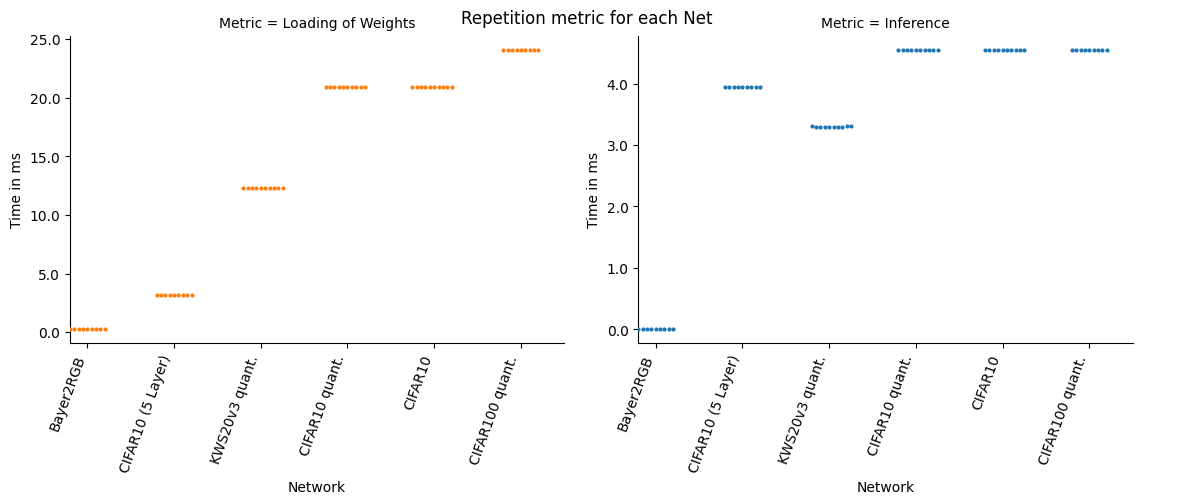

<Figure size 640x480 with 0 Axes>

In [6]:
repetition_per_network = df_percents.copy()
#print(repetition_per_network)

# Drop NaNs for the relevant columns
metrics = ['Loading of Weights', 'Inference',] #, 'Loading of Inputs'
df_clean = repetition_per_network.dropna(subset=metrics)

# Melt the DataFrame to long format for easier plotting
df_melted = df_clean.sort_values(by=['network_size']).melt(id_vars='Network', value_vars=metrics, var_name='Metric', value_name='Value')

# Use FacetGrid to create separate plots for each network
g = sns.FacetGrid(df_melted, col='Metric', sharey=False, height=4, aspect=1.5, margin_titles=True)

palette = sns.color_palette("Greys", n_colors=6)
# Map violinplot to the grid for each metric
g.map_dataframe(sns.swarmplot, x='Network', y='Value', size=3)
#sns.swarmplot(x='Network', y='Value', hue='Metric', data=df_melted)


# Rotate the x-axis labels
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='right')
# Adjust x-axis limits if needed for compactness
for i, ax in enumerate(g.axes.flatten()):
    ax.set_xlim(-0.2, 5.5)  # Adjust based on number of metrics
    metric = ['inference', 'weights_loading'][i]
    for coll in ax.collections:
        coll.set_color(color_for_metric[metric])
    ax.set_yticklabels([f"{y/1000}" for y in ax.get_yticks()])
    ax.set_ylabel('Time in ms')

# Add a legend and adjust the layout
g.add_legend()
plt.subplots_adjust(wspace=0.15)
plt.suptitle("Repetition metric for each Net")
plt.show()
plt.savefig(figures_path / "05_repetition_metrics_per_network.pdf", format='pdf')

             Network              Metric    Value   Mean_Value  Absolute Precision  Relative Precision
0          Bayer2RGB  Loading of Weights   276.47   276.432000            0.038000            0.013747
1          Bayer2RGB  Loading of Weights   276.44   276.432000            0.008000            0.002894
2          Bayer2RGB  Loading of Weights   276.44   276.432000            0.008000            0.002894
3          Bayer2RGB  Loading of Weights   276.44   276.432000            0.008000            0.002894
4          Bayer2RGB  Loading of Weights   276.41   276.432000           -0.022000           -0.007959
..               ...                 ...      ...          ...                 ...                 ...
111  CIFAR100 quant.           Inference  4555.46  4555.564444           -0.104444           -0.002293
112  CIFAR100 quant.           Inference  4556.41  4555.564444            0.845556            0.018561
113  CIFAR100 quant.           Inference  4555.73  4555.564444           

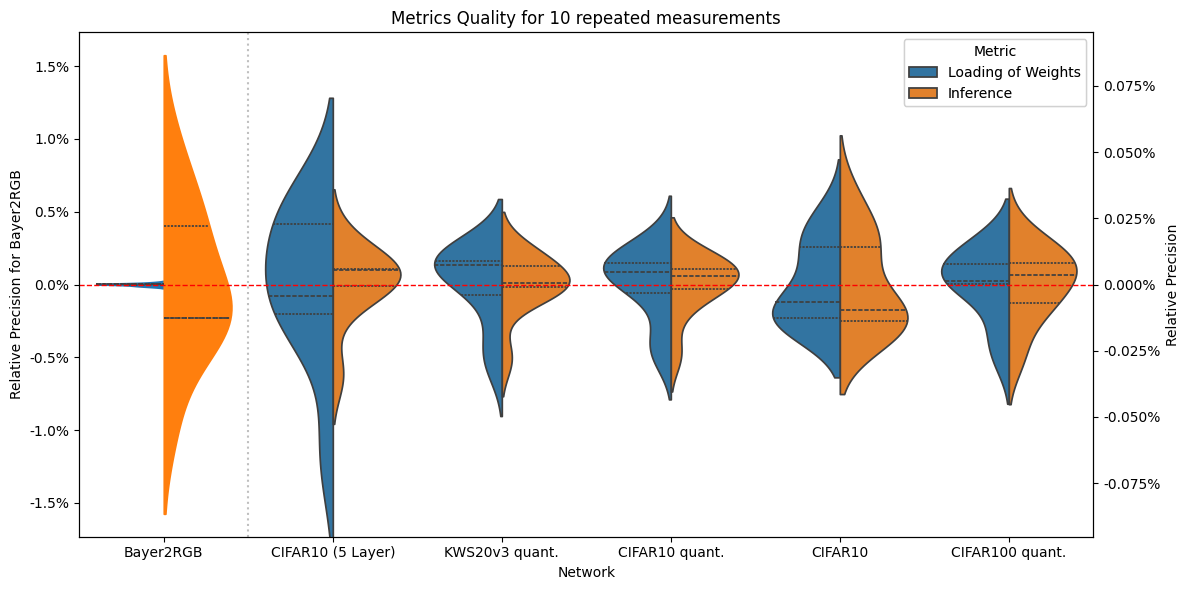

<Figure size 640x480 with 0 Axes>

In [7]:
# Melt the DataFrame to long format for easier plotting
df_melted = df_clean.sort_values(by=['network_size']).melt(id_vars='Network', value_vars=metrics, var_name='Metric', value_name='Value')


mean_values = df_melted.dropna(subset=['Value']).groupby(['Network', 'Metric'])['Value'].mean().reset_index()
mean_values.rename(columns={'Value': 'Mean_Value'}, inplace=True)

# Step 2: Merge to get the mean in the original DataFrame
df_with_mean = df_melted.merge(mean_values, on=['Network', 'Metric'])

# Step 3: Calculate the relative precision
df_with_mean['Absolute Precision'] = df_with_mean['Value'] - df_with_mean['Mean_Value']
df_with_mean['Relative Precision'] = df_with_mean['Absolute Precision'] / df_with_mean['Mean_Value'] * 100 # in percent

# Step 4: Compute the logarithmic relative precision
#df_with_mean['Log_Relative_Precision'] = np.log1p(df_with_mean['Relative_Precision'])

print(df_with_mean)

# Step 5: Calculate the t-test correction
# Grouping by Network and Metric to get mean and standard deviation
group_stats = df_with_mean.groupby(['Network', 'Metric'])['Relative Precision'].agg(['mean', 'std', 'count']).reset_index()

# Step 6: Calculate the t-statistic and corrected values (e.g., confidence interval)
# Assuming you want the confidence interval around the mean
confidence = 0.95
t_critical = stats.t.ppf((1 + confidence) / 2., group_stats['count'] - 1)  # Two-tailed
group_stats['margin_of_error'] = t_critical * (group_stats['std'] / np.sqrt(group_stats['count']))
group_stats['Lower_CI'] = group_stats['mean'] - group_stats['margin_of_error']
group_stats['Upper_CI'] = group_stats['mean'] + group_stats['margin_of_error']

print(group_stats)

# Step 7: Create violin plots for logarithmic relative precision with swapped axes
plt.figure(figsize=(12, 6))
if 1:
    ax = sns.violinplot(x='Network', y='Relative Precision', hue='Metric', data=df_with_mean[df_with_mean["Network"] == "Bayer2RGB"], 
                   split=True,
                   width=0.8,        # Increase width (default is usually 0.8)
                   inner='quartile', # Shows quartile marks inside
                   density_norm='width',
                   )  # Set inner=None to avoid drawing the boxplot
    ax.set_ylabel("Relative Precision for Bayer2RGB")
    ax.yaxis.set_major_formatter(lambda x, pos: f'{x:.1f}%')
    for metricindex, coll in enumerate(ax.collections):
        metric = ['weights_loading', 'inference'][metricindex]
        coll.set_color(color_for_metric[metric])
        print(coll.get_label())

    # now the rest of the plots
    plt.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
    ax2 = ax.twinx()
    sns.violinplot(x='Network', y='Relative Precision', hue='Metric', data=df_with_mean[df_with_mean["Network"] != "Bayer2RGB"], 
                   split=True,
                   width=0.8,        # Increase width (default is usually 0.8)
                   inner='quartile', # Shows quartile marks inside
                   density_norm='width',
                   ax=ax2,
                   )  # Set inner=None to avoid drawing the boxplot
    ax2.set_ylabel("Relative Precision")
    ax2.yaxis.set_major_formatter(lambda x, pos: f'{x:.3f}%')
    for metricindex, coll in enumerate(ax.collections):
        metric = ['weights_loading', 'inference'][metricindex]
        coll.set_color(color_for_metric[metric])
    

    ylim1 = ax.get_ylim()
    ylim2 = ax2.get_ylim()
    
    # Find the relative position of 0 in data coordinates for both axes
    zero_pos1 = -ylim1[0] / (ylim1[1] - ylim1[0])  # relative position of 0 in axis 1
    zero_pos2 = -ylim2[0] / (ylim2[1] - ylim2[0])  # relative position of 0 in axis 2
    
    # if the scaling of ylim1 is more favorable, use by setting extendable_axis = ax2
    extendable_axis = ax2  # or ax, depending on which one you want to move
    current_range = ylim2[1] - ylim2[0]  # preserve the range
    
    # Shift the limits to align 0 while preserving the range
    ylim_min = -(zero_pos1 * current_range)
    ylim_max = ylim_min + current_range
    
    extendable_axis.set_ylim(ylim_min, ylim_max)
else:
    sns.swarmplot(x='Network', y='Relative_Precision', hue='Metric', data=df_with_mean)

# Set x-ticks and rotate labels
#plt.xticks(rotation=45)
plt.title('Metrics Quality for 10 repeated measurements')
plt.ylabel('Relative Precision')
plt.xlabel('Network')
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add a line at y=0 for reference
plt.legend(title='Metric')
plt.tight_layout()
plt.show()
plt.savefig(figures_path / "05_repetition_metrics_per_network_accuracy.pdf", format='pdf')

## Metrics between nets and flashing vs not flashing

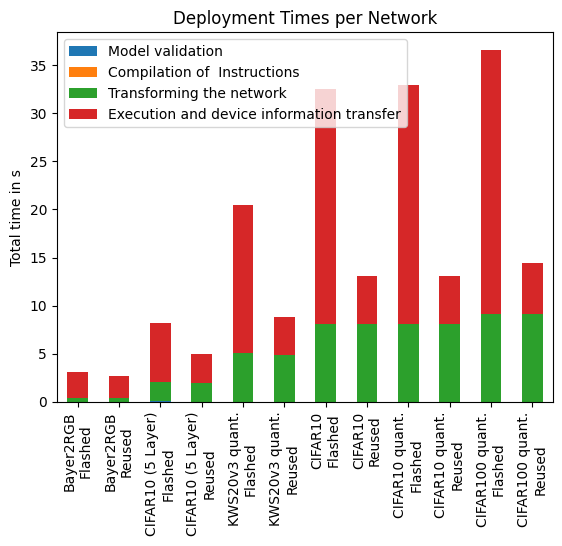

<Figure size 640x480 with 0 Axes>

In [8]:
# print(df_filtered.columns)
df_percents = pd.DataFrame()
df_percents['Option'] = df_filtered['option___reflash'].apply(lambda x: 'Flashed' if x else 'Reused')
df_percents['Network'] = df['option_network_name'].apply(lambda x: nice_network_names[x])
df_percents['network_size'] =  df['option_network_name'].apply(lambda x: weights[x])

selected_fields=['_check_model', 'compile_instructions', 'layout_transform', 'execute', ]

for k in selected_fields:
    df_percents[nice_colnames[k]] = df_filtered[k] #/ df_filtered['us_per_all']

df_percents_indexed = df_percents.set_index(['Network', 'Option'])
df_percents_grouped = df_percents_indexed.groupby(['Network', 'Option']).mean().sort_values(by=['network_size'])

df_percents_grouped.index = [f'{net}\n{option}' for net, option in df_percents_grouped.index]


# Plot the stacked bar chart
df_percents_grouped[[nice_colnames[k] for k in selected_fields]].plot(kind='bar', stacked=True)

plt.ylabel('Total time in s')
plt.title('Deployment Times per Network')
plt.show()
plt.savefig(figures_path / "05_deployment_times.pdf", format='pdf')

Average flashing overhead relative to Network size: 267.38%
fit coefficients: [1.13658956e-05 4.62855151e-01]


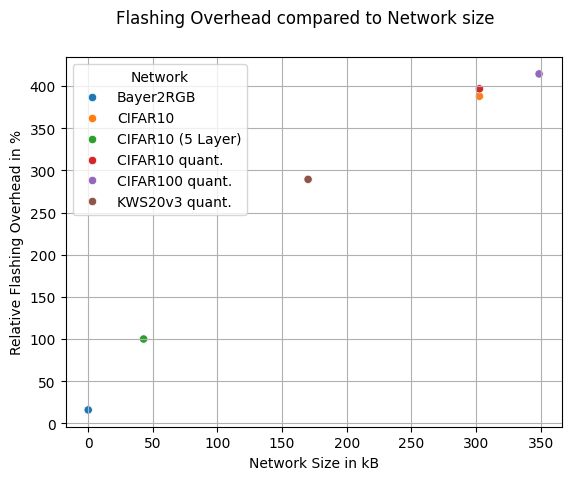

<Figure size 640x480 with 0 Axes>

In [9]:
# print(df_percents)
# Group by 'Network' and calculate mean of 'Execution' for both "Flashed" and "Reused"
flashed_mean = df_percents[df_percents['Option'] == "Flashed"].groupby('Network')[nice_colnames['execute']].mean()
reused_mean = df_percents[df_percents['Option'] == "Reused"].groupby('Network')[nice_colnames['execute']].mean()
network_size_mean= df_percents.groupby('Network')['network_size'].mean()

# Compare the means per network
comparison = pd.DataFrame({
    'Flashed Mean': flashed_mean,
    'Reused Mean': reused_mean,
    'Overhead in s': (flashed_mean - reused_mean),
    'Relative Flashing Overhead': (flashed_mean - reused_mean) / reused_mean,
    'Network Size': network_size_mean,
    'Network Size in kB': network_size_mean/1000,
    'realtive Network Size': network_size_mean.apply(lambda x: 100*x/network_size_mean.max()),
})
comparison['Relative Flashing Overhead in %'] = comparison['Relative Flashing Overhead'] *100
comparison['Relative Flashing Overhead\n in % to logarithmic Network Size'] = comparison['Relative Flashing Overhead in %'] / np.log(comparison['Network Size in kB'])
# print(comparison)
flash_overhead_value = (comparison['Relative Flashing Overhead'] *100).mean()
print(f"Average flashing overhead relative to Network size: {flash_overhead_value:2.2f}%")

#=============================================

fitted = np.polyfit(comparison['Network Size'], comparison['Relative Flashing Overhead'], 1)
print("fit coefficients:", fitted)

# Plotting the scatter and fitted log curve
# fig, axes = plt.subplots(1,2,figsize=(12,3))
ax = sns.scatterplot(
    # ax=axes[0],
    data=comparison, x='Network Size in kB', y='Relative Flashing Overhead in %', hue='Network')
# ax2 = sns.scatterplot(ax=axes[1],data=comparison, x='Network Size in kB', y='Relative Flashing Overhead\n in % to logarithmic Network Size', hue='Network')
ax.grid()
# ax2.grid()
# Generate x values for plotting the log fit
x = np.linspace(min(comparison['Network Size']), max(comparison['Network Size']), 1000)

# Plot the logarithmic fit
#plt.plot(x, np.polyval(x, fitted), label="Log fit", color='orange')

#plt.legend()
plt.suptitle('Flashing Overhead compared to Network size')
plt.show()
plt.savefig(figures_path / "05_deployment_times_overhead.pdf", format='pdf')

/tmp/ipykernel_3192683/3653634213.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{weight/1000:1.0f}k' if weight != 0 else '0' for weight in ax.get_xticks()])


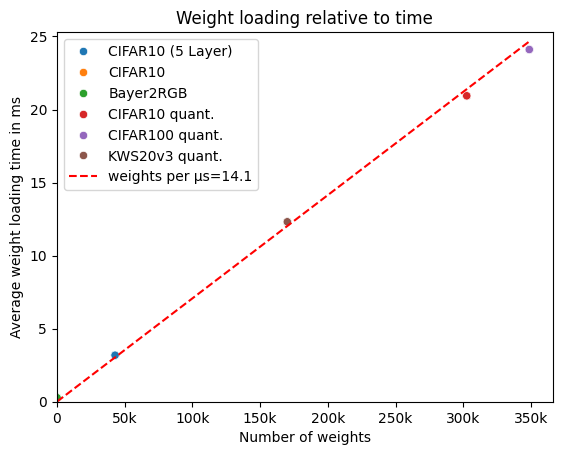

In [10]:
# plot time per weight as a plot with the 'network_name' as hue
df_per_weights = df_filtered.copy().dropna(subset=['us_per_weights_loading'])
df_per_weights['Network'] = df['option_network_name'].apply(lambda x: nice_network_names[x])
df_per_weights['weight_count'] = df['option_network_name'].apply(lambda x: weights[x])
df_per_weights['us_per_weights_loading'] = df_per_weights['us_per_weights_loading'].apply(lambda x: x/1000)
df_per_weights['perform'] = df_per_weights['weight_count'] / df_per_weights['us_per_weights_loading']

ax = sns.scatterplot(data=df_per_weights, x='weight_count', y='us_per_weights_loading', hue='Network',)
ax.set_xlim([0, ax.get_xlim()[1]])
ax.set_ylim([0, ax.get_ylim()[1]])
ax.set_xticklabels([f'{weight/1000:1.0f}k' if weight != 0 else '0' for weight in ax.get_xticks()])


loading_constant = 1.0/(df_per_weights[df_per_weights['perform'] > 1000]['perform']).mean()

ax = plt.plot(np.linspace( df_per_weights['weight_count'].min(),  df_per_weights['weight_count'].max(), 100),
         loading_constant * np.linspace(df_per_weights['weight_count'].min(), df_per_weights['weight_count'].max(), 100),
         color='red', linestyle='--', label=f'weights per µs={0.001/loading_constant:0.1f}')

plt.xlabel("Number of weights")
plt.ylabel("Average weight loading time in ms")
plt.title('Weight loading relative to time')
plt.legend()

# mean = (df_per_weights[df_per_weights['perform'] > 1000]['perform']).mean() # 14232
# df_per_weights[['weight_count', 'Network', 'us_per_weights_loading','perform']]

plt.savefig(figures_path / "05_weight_loading_relative_to_time.pdf", format='pdf')

# compare energy per network

/tmp/ipykernel_3192683/1992711637.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')


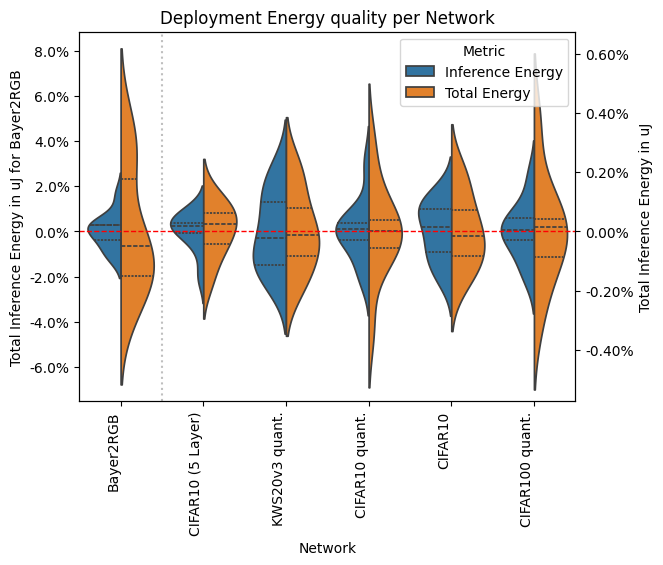

<Figure size 640x480 with 0 Axes>

In [11]:
# print(df_filtered.columns)
df_percents = pd.DataFrame()
# df_percents['Option'] = df_filtered['option___reflash'].apply(lambda x: 'Flashed' if x else 'Reused')
df_percents['Network'] = df['option_network_name'].apply(lambda x: nice_network_names[x])
df_percents['network_size'] =  df['option_network_name'].apply(lambda x: weights[x])
df_percents['Total Energy'] =  df['uJ_per_all']
df_percents['Inference Energy'] =  df['uJ_per_inference']
df_percents_filtered = df_percents.dropna(subset=['Total Energy'])
# Melt the DataFrame to long format for easier plotting
df_melted = df_percents_filtered.sort_values(by=['network_size']).melt(id_vars='Network', value_vars=['Inference Energy', 'Total Energy'], var_name='Metric', value_name='Value')

mean_values = df_melted.dropna(subset=['Value']).groupby(['Network', 'Metric'])['Value'].mean().reset_index()
mean_values.rename(columns={'Value': 'Mean_Value'}, inplace=True)

# Step 2: Merge to get the mean in the original DataFrame
df_with_mean = df_melted.merge(mean_values, on=['Network', 'Metric'])

# Step 3: Calculate the relative precision
df_with_mean['Absolute Precision'] = df_with_mean['Value'] - df_with_mean['Mean_Value']
df_with_mean['Relative Precision'] = df_with_mean['Absolute Precision'] / df_with_mean['Mean_Value'] * 100 # in percent

# Step 4: Compute the logarithmic relative precision
#df_with_mean['Log_Relative_Precision'] = np.log1p(df_with_mean['Relative_Precision'])

selected_fields=['_check_model', 'compile_instructions', 'layout_transform', 'execute', ]

for k in selected_fields:
    df_percents[nice_colnames[k]] = df_filtered[k] #/ df_filtered['us_per_all']


if 1:
    ax = sns.violinplot(x='Network', y='Relative Precision', hue='Metric', data=df_with_mean[df_with_mean["Network"] == "Bayer2RGB"], 
                    split=True,
                    width=0.8,        # Increase width (default is usually 0.8)
                    inner='quartile', # Shows quartile marks inside
                    density_norm='width',
                    )  # Set inner=None to avoid drawing the boxplot
    ax.set_ylabel('Total Inference Energy in uJ for Bayer2RGB')
    ax.yaxis.set_major_formatter(lambda x, pos: f'{x:.1f}%')
    # for metricindex, coll in enumerate(ax.collections):
    #     metric = ['weights_loading', 'inference'][metricindex]
    #     coll.set_color(color_for_metric[metric])
    ax.get_legend().remove()

    # now the rest of the plots
    plt.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
    ax2 = ax.twinx()
    sns.violinplot(x='Network', y='Relative Precision', hue='Metric', data=df_with_mean[df_with_mean["Network"] != "Bayer2RGB"], 
                    split=True,
                    width=0.8,        # Increase width (default is usually 0.8)
                    inner='quartile', # Shows quartile marks inside
                    density_norm='width',
                    ax=ax2,
                    )  # Set inner=None to avoid drawing the boxplot
    ax2.yaxis.set_major_formatter(lambda x, pos: f'{x:.2f}%')
    ax2.get_legend().remove()

    # for metricindex, coll in enumerate(ax.collections):
    #     metric = ['weights_loading', 'inference'][metricindex]
    #     coll.set_color(color_for_metric[metric])


    ylim1 = ax.get_ylim()
    ylim2 = ax2.get_ylim()

    # Find the relative position of 0 in data coordinates for both axes
    zero_pos1 = -ylim1[0] / (ylim1[1] - ylim1[0])  # relative position of 0 in axis 1
    zero_pos2 = -ylim2[0] / (ylim2[1] - ylim2[0])  # relative position of 0 in axis 2

    # if the scaling of ylim1 is more favorable, use by setting extendable_axis = ax2
    extendable_axis = ax2  # or ax, depending on which one you want to move
    current_range = ylim2[1] - ylim2[0]  # preserve the range

    # Shift the limits to align 0 while preserving the range
    ylim_min = -(zero_pos1 * current_range)
    ylim_max = ylim_min + current_range

    extendable_axis.set_ylim(ylim_min, ylim_max)


    ax2.set_ylabel('Total Inference Energy in uJ')
plt.xlabel('Network')
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add a line at y=0 for reference

# plt.xticks(rotation=45)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
plt.legend(title='Metric', loc='upper right')
plt.title('Deployment Energy quality per Network')
plt.show()
plt.tight_layout()

plt.savefig(figures_path / "05_deployment_energy.pdf", format='pdf')

In [152]:
option = 'option_GCR.pclkdiv.cnnclkdiv'

ValueError: Could not interpret value `option_GCR.pclkdiv.cnnclkdiv` for `hue`. An entry with this name does not appear in `data`.

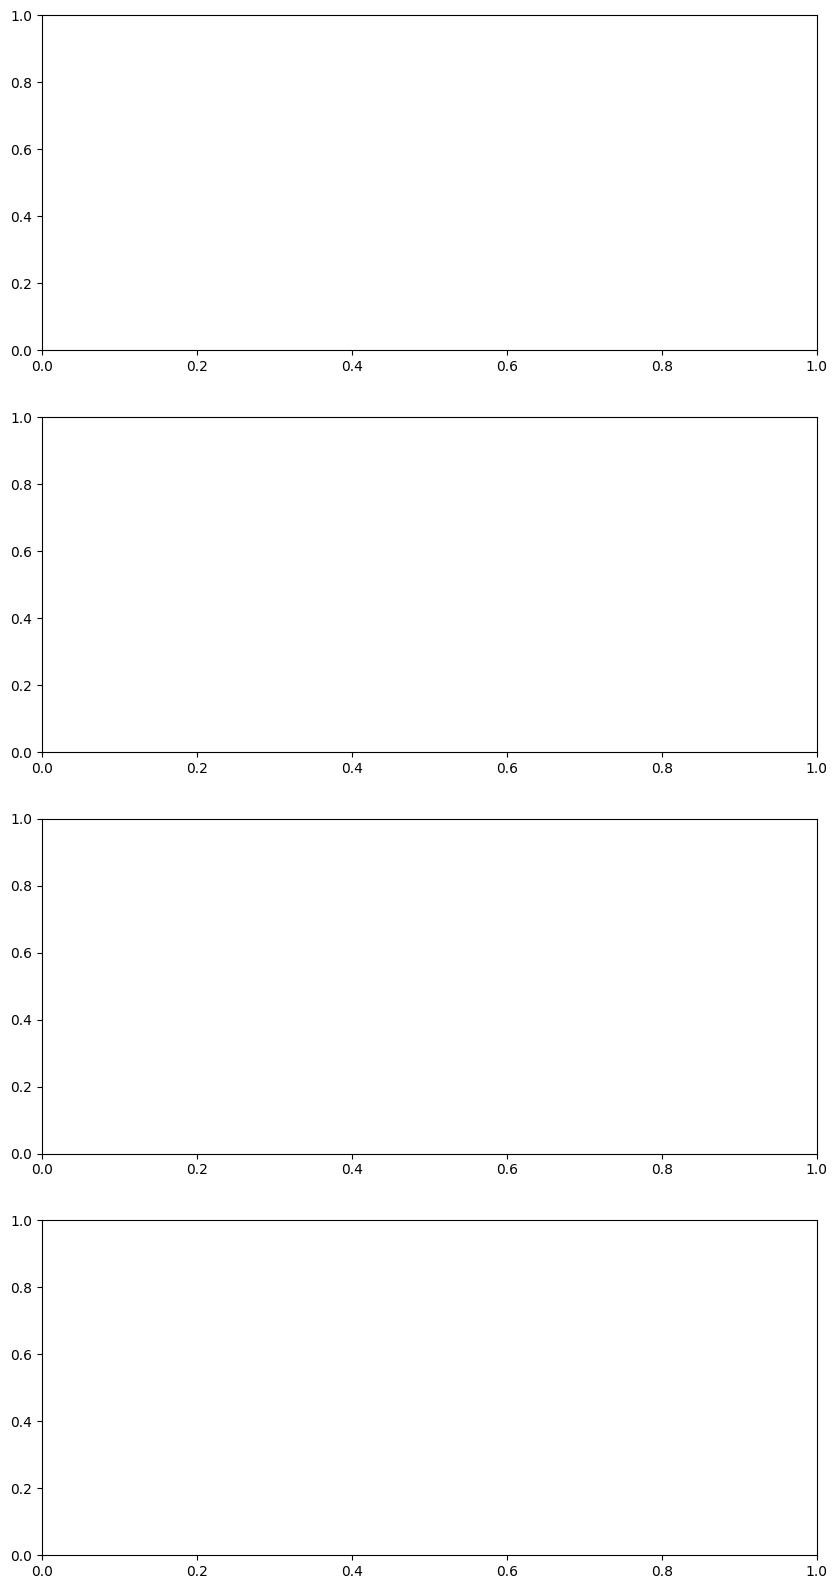

In [214]:
# Define the list of metric pairs for plotting
metric_pairs = [
    ('us_per_all', 'uW_per_all'),
    ('us_per_inference', 'uW_per_inference'),
    ('us_per_input_loading', 'uW_per_input_loading'),
    ('us_per_weights_loading', 'uW_per_weights_loading'),
]
# Set up subplots based on the number of pairs
fig, axes = plt.subplots(len(metric_pairs), 1, figsize=(10, 5 * len(metric_pairs)))  # Adjust height as needed

# Plot each pair
for i, (x_metric, y_metric) in enumerate(metric_pairs):
    ax1 = axes[i]  # Get the current subplot axis

    # Check if y_metric is a tuple (for dual y-axes)
    if isinstance(y_metric, tuple):
        # Plot the first y metric on the primary y-axis
        y1 = y_metric[0]
        sns.boxplot(
            data=df_filtered, x=x_metric, y=y1, ax=ax1,
            hue=option,
            # label=y1,
            palette='Set2',
            # alpha=0.7,
            # multiple='dodge',
            )

        # Create a second y-axis for the second metric
        ax2 = ax1.twinx()  # Create a twin y-axis
        y2 = y_metric[1]
        sns.boxplot(
            data=df_filtered, x=x_metric, y=y2, ax=ax2,
            hue=option,
            # label=y2,
            palette='Set2',
            # alpha=0.7,
            # multiple='dodge',
            )
    else:
        # Plot the single y metric on the primary y-axis
        sns.boxplot(
            data=df_filtered, x=x_metric, y=y_metric, ax=ax1,
            hue=option,
            # label=y_metric,
            palette='Set2',
            # alpha=0.7,
            # multiple='dodge',
            )

    # Set title for each subplot
    ax1.set_title(f'{x_metric} vs {y_metric if not isinstance(y_metric, tuple) else y_metric[0]}')

# Set title for the overall plot
plt.suptitle('Scatter Plot of Metric Pairs', fontsize=16)

# Create a global legend using handles and labels from the plot
# handles, labels = plt.gca().get_legend_handles_labels()  # Get handles and labels from the current axis
# plt.legend(handles, labels, title='Experiment', loc='upper right')
plt.tight_layout(rect=[0,0,1,0.99])
plt.show()

ValueError: Could not interpret value `option_GCR.pclkdiv.cnnclkdiv` for `hue`. An entry with this name does not appear in `data`.

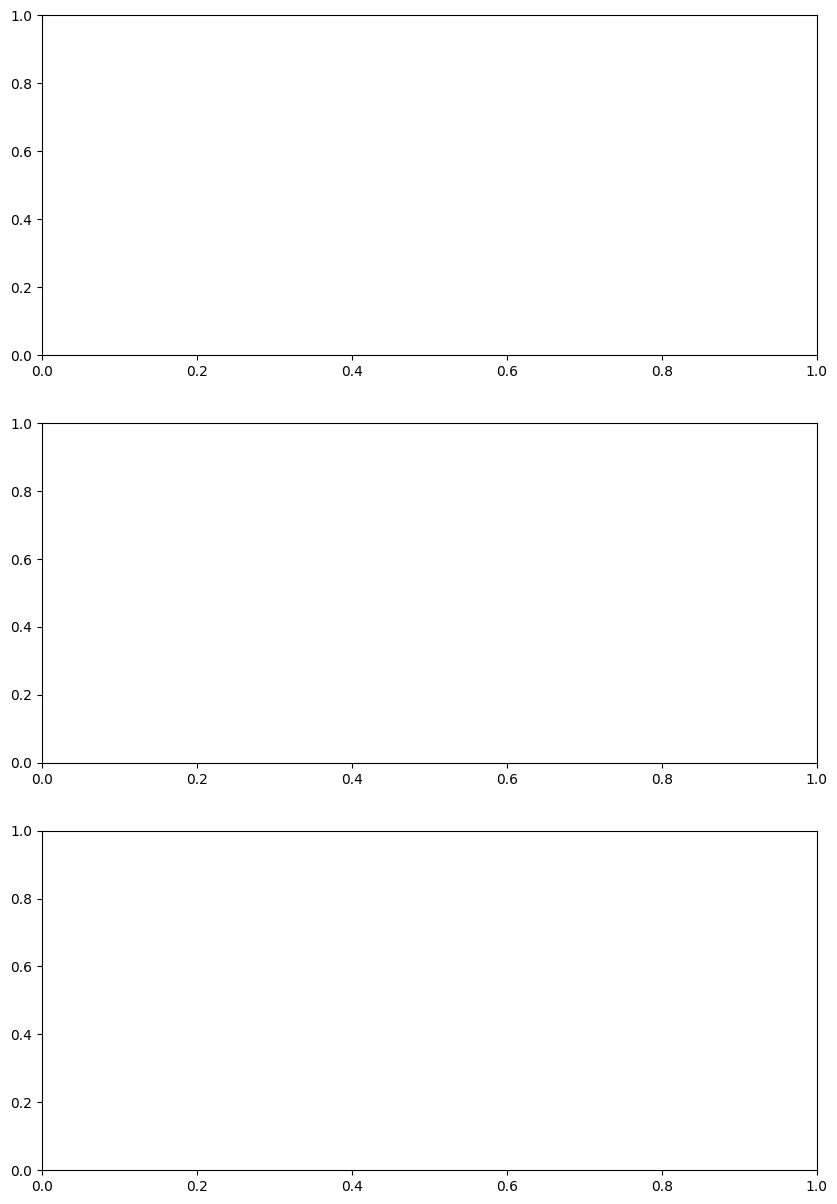

In [213]:
# Define the list of metric pairs for plotting
metric_pairs = [
    ('us_per_all', 'uJ_per_all'),
    ('us_per_all', 'uW_per_all'),
    ('us_per_all', 'us_per_weights_loading'),
]

# Set up subplots based on the number of pairs
fig, axes = plt.subplots(len(metric_pairs), 1, figsize=(10, 5 * len(metric_pairs)))  # Adjust as needed

# Plot each pair
for i, (x_metric, y_metric) in enumerate(metric_pairs):
    sns.scatterplot(data=df_filtered, x=x_metric, y=y_metric, hue=option, ax=axes[i], palette='Set2', alpha=0.7)
    # Set title for each subplot
    axes[i].set_title(f'{x_metric} vs {y_metric}')

# Create a global legend using handles and labels from the first axis
handles, labels = axes[0].get_legend_handles_labels()  # Get handles and labels from the first axis
fig.legend(handles, labels, loc='upper right', title='Experiment')

# Set the overall title for the figure
fig.suptitle('Dependencies of Metrics', fontsize=16)

plt.tight_layout()
plt.show()

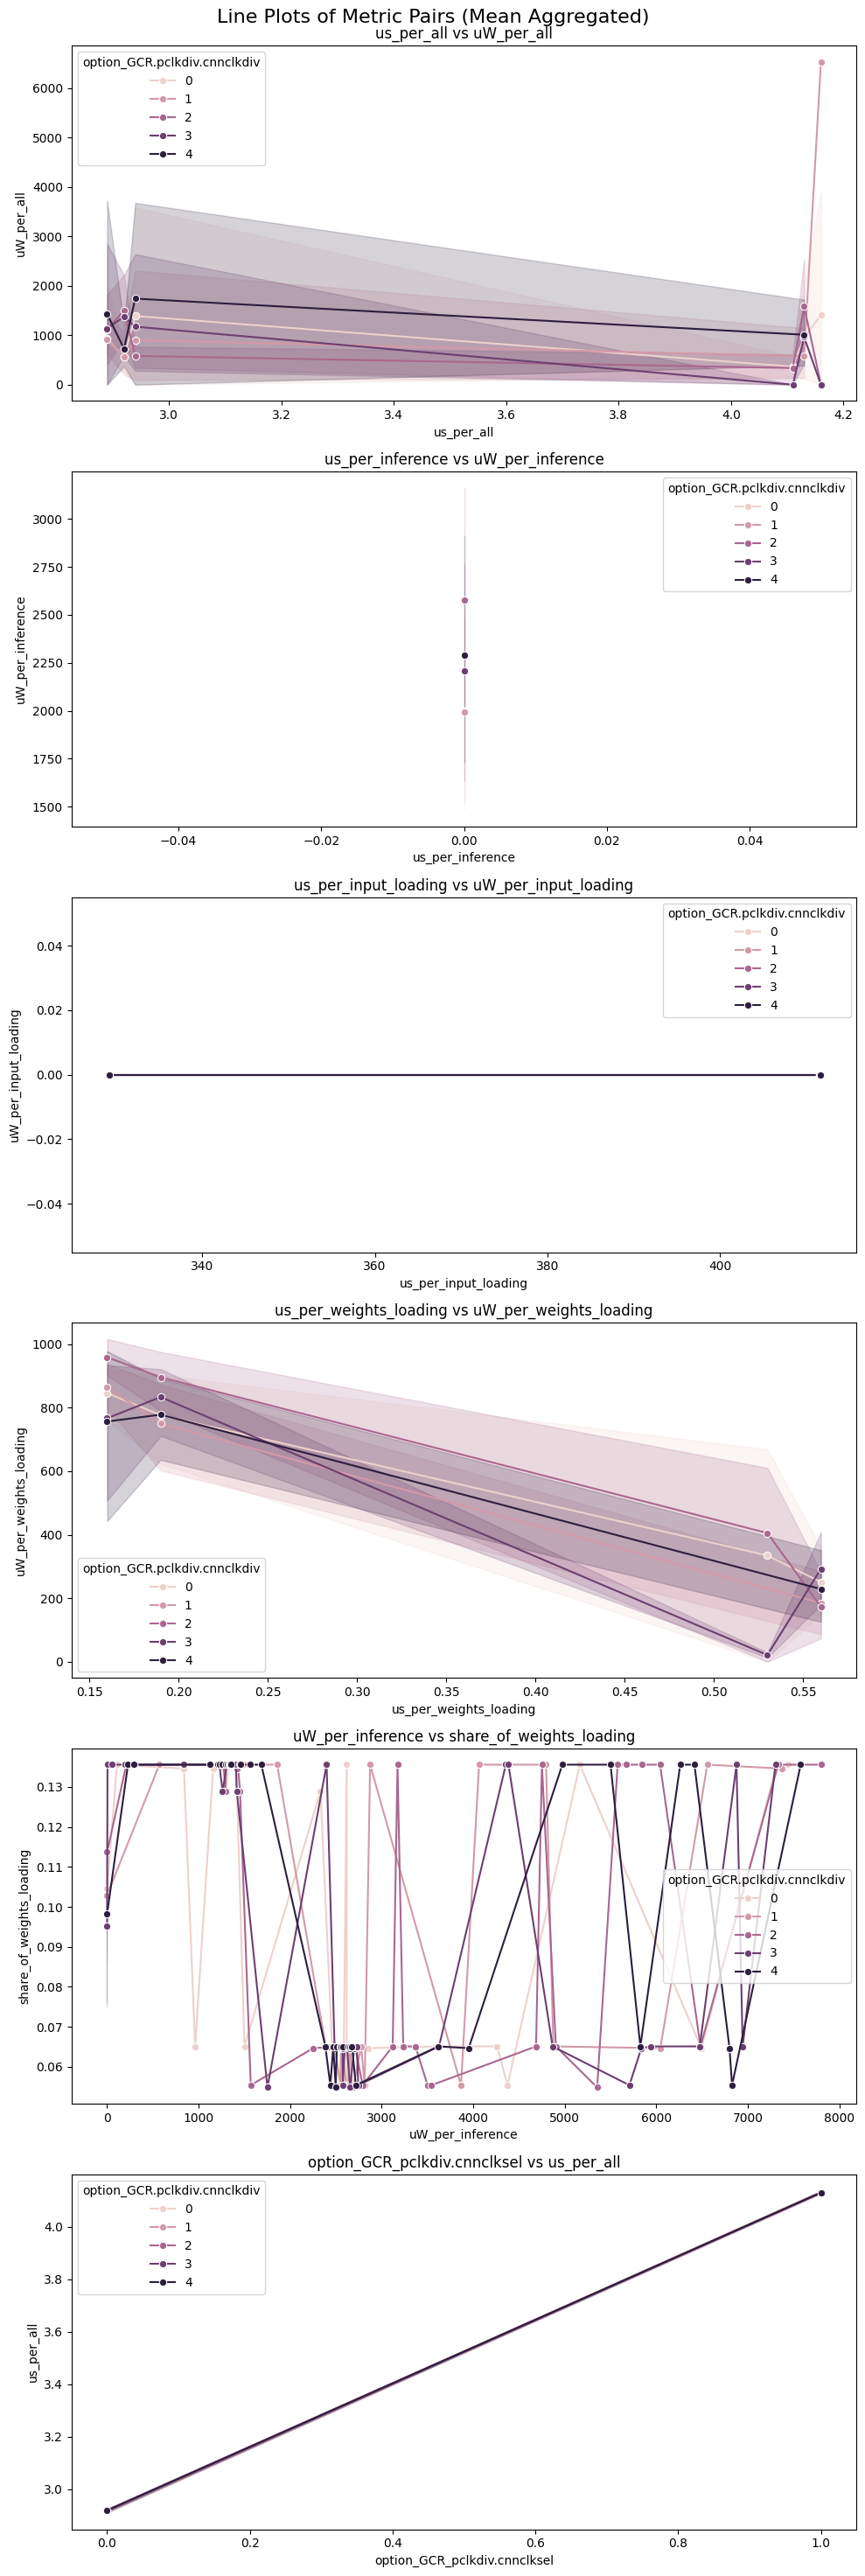

In [ ]:
metric_pairs2 = metric_pairs +[
    ('uW_per_inference', 'share_of_weights_loading'),
    ('option_GCR_pclkdiv.cnnclksel', 'us_per_all'),
]

# Set up the plot
fig, axes = plt.subplots(len(metric_pairs2), 1, figsize=(10, 5 * len(metric_pairs2)))  # Adjust height as needed

# Plot each pair
for i, (x_metric, y_metric) in enumerate(metric_pairs2):
    ax = axes[i]  # Get the current subplot axis
    
    # Group by the x metric and calculate the mean for the y metric(s)
    if isinstance(y_metric, tuple):
        y1 = y_metric[0]
        y2 = y_metric[1]

        # Group and calculate means
        mean_df1 = df_filtered.groupby(x_metric, as_index=False)[y1].mean()
        mean_df2 = df_filtered.groupby(x_metric, as_index=False)[y2].mean()

        # Plot the first metric
        sns.lineplot(data=mean_df1, x=x_metric, y=y1, ax=ax, hue=option, marker='o')
        
        # Plot the second metric on the same axis
        sns.lineplot(data=mean_df2, x=x_metric, y=y2, ax=ax, hue=option, marker='o')
        
    else:
        if y_metric == option:
            # Group and calculate means
            mean_df = df_filtered.groupby([x_metric, option], as_index=False)[y_metric].mean()
            sns.lineplot(data=mean_df, x=x_metric, y=y_metric, ax=ax, marker='o')
        else:
            # Group and calculate means
            mean_df = df_filtered.groupby([x_metric, option], as_index=False)[y_metric].mean()
            sns.lineplot(data=df_filtered, x=x_metric, y=y_metric, ax=ax, hue=option, marker='o')

    # Set title for each subplot
    ax.set_title(f'{x_metric} vs {y_metric if not isinstance(y_metric, tuple) else y_metric[0]}')

# Set the overall title for the figure
fig.suptitle('Line Plots of Metric Pairs (Mean Aggregated)', fontsize=16)

# # Create a global legend using handles and labels from the first subplot
# handles, labels = axes[0].get_legend_handles_labels()  # Get handles and labels from the first subplot
# fig.legend(handles, labels, title='Metrics', loc='upper right')

plt.tight_layout(rect=[0,0,1,0.99])
plt.show()